 **KLASIFIKASI 2 MOTIF BATIK**


Mengambil Dataset dari Github

In [1]:
!apt-get install subversion > /dev/null

!svn export https://github.com/Kuliah-Machine-Learning/2021-Batik-Kel-8/trunk/data > /dev/null

Memasukkan Fungsi Library

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

In [3]:
#Perintah di bawah ini untuk melihat list bagian dari file yang sudah diunduh dari Github
!ls data/
!ls data/train
!ls data/train/Kawung
!ls data/train/Megamendung

test  train
Kawung	Megamendung
K10.jpg  K16.jpg   K21.jpg  K27.jpg  K32.jpg  K38.jpg  K43.png	 K7.jpg
K11.jpg  K17.jpeg  K22.jpg  K28.jpg  K33.jpg  K39.jpg  K44.jpg	 K8.jpg
K12.jpg  K18.jpg   K23.jpg  K29.jpg  K34.jpg  K3.jpg   K45.jpeg  K9.jpg
K13.jpg  K19.jpg   K24.jpg  K2.jpg   K35.jpg  K40.jpg  K4.jpg
K14.jpg  K1.jpg    K25.jpg  K30.png  K36.jpg  K41.jpg  K5.jpg
K15.png  K20.jpg   K26.jpg  K31.jpg  K37.jpg  K42.jpg  K6.jpg
M10.jpg  M15.jpg  M1.jpg   M24.jpg  M29.jpg  M33.jpg   M38.jpg	M42.jpg  M5.jpg
M11.jpg  M16.jpg  M20.jpg  M25.jpg  M2.jpg   M34.jpg   M39.jpg	M43.jpg  M6.jpg
M12.jpg  M17.jpg  M21.jpg  M26.jpg  M30.jpg  M35.jpeg  M3.jpg	M44.jpg  M7.jpg
M13.jpg  M18.jpg  M22.jpg  M27.jpg  M31.jpg  M36.jpg   M40.jpg	M45.jpg  M8.jpg
M14.jpg  M19.jpg  M23.jpg  M28.jpg  M32.jpg  M37.jpg   M41.jpg	M4.jpg	 M9.jpg


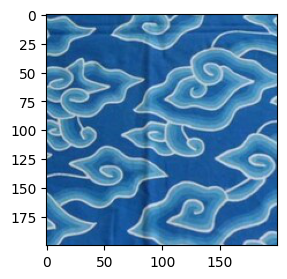

In [4]:
#Perintah untuk memvisualisasikan satu gambar dari data train
image = imread("data/train/Megamendung/M1.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [5]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 200
BATCH_SIZE = 82
base_dir = os.path.join('data/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.1)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Kawung', 'Megamendung']

for i,label in enumerate(labels):
    folder = os.path.join("data/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(200,200))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 82 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Bentuk array dari dataset train (pelatihan) adalah: (82, 200, 200, 3) (82, 2)
Bentuk array dari dataset validation (validasi) adalah: (8, 200, 200, 3) (8, 2)
Bentuk array dari dataset test (pengujian) adalah: (8, 200, 200, 3) (8,)


In [6]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Kawung': 0, 'Megamendung': 1}


In [7]:
!cat labels.txt

Kawung
Megamendung

Membuat Model dari Jaringan CNN yang Sudah dipelajari Sebelumnya (pre-trained convnets)

In [8]:
IMG_SHAPE = (200, 200, 3)
# Membuat model dasar (base model) dari pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


*Feature Extraction*

In [9]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

Mengelompokkan Klasifikasi Dua Motif Batik dengan Deep learning (Convolutional Neural Network)

In [10]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

Menyiapkan Data Masukan Pengujian

In [11]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

Pembuatan Model

In [12]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 2, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          65568     
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 14,780,322
Trainable params: 65,634
Non-trainable params: 14,714,688
_________________________________________________________________


Pelatihan

In [13]:
history = model.fit_generator(train_generator, 
                    epochs=3, 
                    validation_data=val_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/3
1/1 [==============================] - 39s 39s/step - loss: 0.7341 - acc: 0.3537 - val_loss: 0.6283 - val_acc: 0.6250
Epoch 2/3
1/1 [==============================] - 35s 35s/step - loss: 0.6249 - acc: 0.6220 - val_loss: 0.5267 - val_acc: 0.7500
Epoch 3/3
1/1 [==============================] - 35s 35s/step - loss: 0.5182 - acc: 0.7927 - val_loss: 0.4329 - val_acc: 1.0000


Menggambarkan Hasil Pelatihan

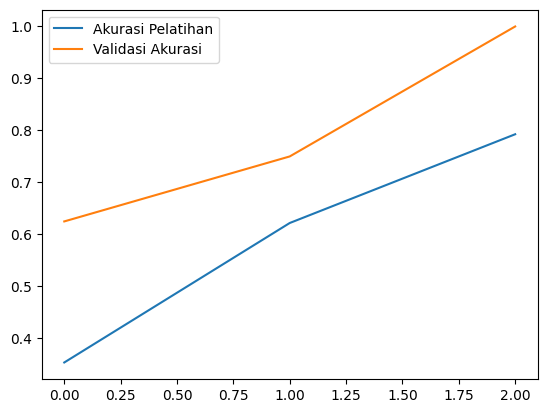

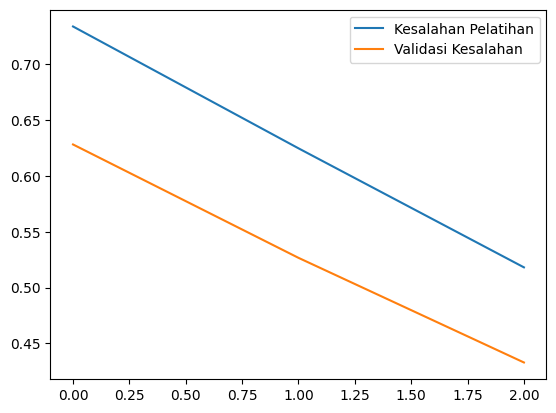

In [14]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [15]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


Menggunakan Model

In [16]:
print(train_generator)

In [17]:
#Prediksi Label Validasi dengan Pelatihan
n = 2
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [1. 0.]
Prediksinya adalah [0.52425927 0.47574064]


Evaluasi

In [18]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_generator))
#Evaluasi validasi data
print(model.evaluate(val_generator))
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3)) 

['loss', 'acc']
1/1 [==============================] - 38s 38s/step - loss: 0.4219 - acc: 0.9390
[0.42193910479545593, 0.9390243887901306]
1/1 [==============================] - 3s 3s/step - loss: 0.4329 - acc: 1.0000
[0.4329051375389099, 1.0]
1/1 [==============================] - 3s 3s/step - loss: 0.3679 - acc: 1.0000
[0.3679216206073761, 1.0]


In [19]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 1 1 1 1]
[0 0 0 0 1 1 1 1]


Prediksi Gambar Individual

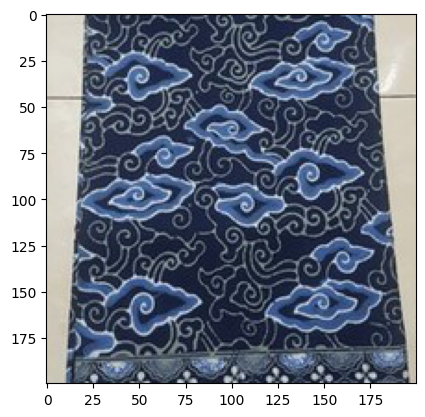

Label yang benar adalah: 1 : Megamendung
Nilai yang diprediksi adalah: [0.36 0.64]
Label yang diprediksi adalah: 1 : Megamendung
Prediksi benar


In [23]:
n = 6 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

*Confusion Matrix*

Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


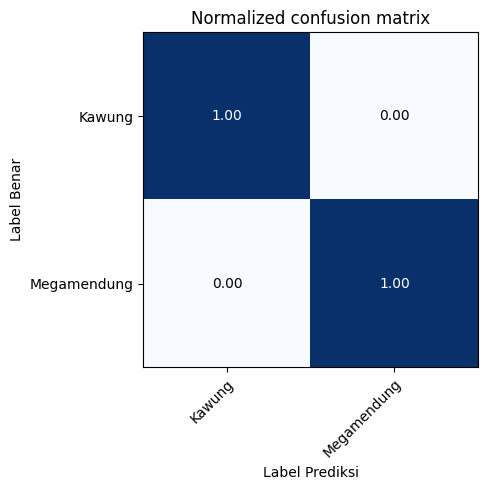

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

Menyimpan dan Konversi ke ".tflite"

In [25]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Klasifikasi_3_Jenis_Beras.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: save/model/assets
